In [17]:
import os
import pypsa 
import matplotlib.pyplot as plt
plt.style.use("bmh")
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns  ###
import cartopy.crs as ccrs
sns.set(style='darkgrid') ### seaborn gives a nice design

In [47]:
os.getcwd()

'/media/max/Seagate/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/scripts'

In [55]:
cd ..

/


In [56]:
cd media/max/Seagate/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/scripts

/media/max/Seagate/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/scripts


In [57]:
from _helpers import *
from make_summary import assign_carriers
from plot_summary import plot_costs

## Upload network

In [58]:
##Upload ALL scnearios

#defines folder where the solved networks are (.nc files)
directory = r'/media/max/Seagate/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/'
network_paths = []
#iterates through all the solved networks
for entry in os.scandir(directory):
    if entry.path.endswith(".nc") and entry.is_file():
        #create a list with all the file paths:
        network_paths.append(entry.path)
    
#Sort list
network_paths.sort()

print("\n".join(network_paths[0:]))


/media/max/Seagate/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00000.nc
/media/max/Seagate/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00001.nc
/media/max/Seagate/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.0001.nc
/media/max/Seagate/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.001.nc
/media/max/Seagate/08_2_SecondPaper/unintended-storage-cycling/Model_script_github-only-h2-all-assets_no_hydro_solver_accuracy2/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.01.nc
/media/max/Seagate/08_2_SecondPaper/

In [59]:
#create a dictionary that contains networks abbr. ns
ns = {}

for i in range(0, len(network_paths)): ##full list
#for i in range(0, 2): ##just testing
    ns["n%s" %(i+10)] = pypsa.Network(network_paths[i])
    
ns

##NOTES. 
#mc_charger = n10-n19
#mc_dicharger = n20-n29
#mc_store = n30-n39
#mc_vre = n40-n49

/home/max/anaconda3/envs/toast/lib/python3.9/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=df.index | columns, fill_value=default)
/home/max/anaconda3/envs/toast/lib/python3.9/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))
INFO:pypsa.io:Imported network elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00000.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
/home/max/anaconda3/envs/toast/lib/python3.9/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical o

{'n10': Network ,
 'n11': Network ,
 'n12': Network ,
 'n13': Network ,
 'n14': Network ,
 'n15': Network ,
 'n16': Network ,
 'n17': Network ,
 'n18': Network ,
 'n19': Network ,
 'n20': Network ,
 'n21': Network ,
 'n22': Network ,
 'n23': Network ,
 'n24': Network ,
 'n25': Network ,
 'n26': Network ,
 'n27': Network ,
 'n28': Network ,
 'n29': Network ,
 'n30': Network ,
 'n31': Network ,
 'n32': Network ,
 'n33': Network ,
 'n34': Network ,
 'n35': Network ,
 'n36': Network ,
 'n37': Network ,
 'n38': Network ,
 'n39': Network ,
 'n40': Network ,
 'n41': Network ,
 'n42': Network ,
 'n43': Network ,
 'n44': Network ,
 'n45': Network ,
 'n46': Network ,
 'n47': Network ,
 'n48': Network ,
 'n49': Network }

# Function

In [66]:
def calculate_FLH_assets(n, name, **kwargs):
    #generators
    genenerator_dispatch = n.generators_t.p.sum().groupby(n.generators.carrier).sum()
    genenerator_dispatch_capacity = n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

    #H2 - Already integrated
    # storage_dispatch = n.stores_t.p[(n.stores_t.p[n.stores_t.p.columns] <= 0)].sum().groupby(n.stores.carrier).sum()
    # storage_store = n.stores_t.p[(n.stores_t.p[n.stores_t.p.columns] >= 0)].sum().groupby(n.stores.carrier).sum()
    
    #hydro_PHS
    storage_unit_dispatch = n.storage_units_t.p_dispatch.sum().groupby(n.storage_units.carrier).sum()
    storage_unit_store = n.storage_units_t.p_store.sum().groupby(n.storage_units.carrier).sum()
    storage_unit_capacity = n.storage_units.p_nom.groupby(n.storage_units.carrier).sum()

    #FLH 
    FLH_storage_unit = storage_unit_dispatch/storage_unit_capacity
    FLH_generator = genenerator_dispatch/genenerator_dispatch_capacity
    
    return(name, FLH_generator['offwind-ac'],FLH_generator['offwind-dc'],FLH_generator['onwind'],
           #FLH_generator['ror'],
           FLH_generator['solar'],
           #FLH_storage_unit['PHS'],
           #FLH_storage_unit['hydro']
          )

In [67]:
values = list(ns.values())
keys = list(ns.keys())
FLH_all_assets = []

for i in range(0, len(keys)):
    A = calculate_FLH_assets(values[i], keys[i])
    FLH_all_assets.append(A)


In [71]:
df_FLH_all_assets = pd.DataFrame(
    FLH_all_assets, 
    columns = ['Network','offwind-ac','offwind-dc','onwind',
               #'ror',
               'solar',
               #'PHS',
               #'hydro'
              ])

df_FLH_all_assets['scenario'] = [
    #charger
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #discharger
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #store
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #vre
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    ]

In [72]:
df_FLH_all_assets = df_FLH_all_assets.drop('Network',axis=1).set_index("scenario")

[[0.02022859 0.05163462 0.04526915 0.01593767]
 [0.03567456 0.04809583 0.04216929 0.02110663]
 [0.03299031 0.05143211 0.04158194 0.016719  ]
 [0.02053315 0.04615543 0.03532572 0.01676856]]
           offwind-ac   offwind-dc       onwind       solar
scenario                                                   
0.0       3723.997381  4446.271624  2094.922254  746.611572
0.0       3742.535592  4421.321210  2097.816793  749.610211
0.0       3755.253545  4423.888260  2081.315560  745.193296
0.0       3731.535368  4425.850194  2087.349347  745.953747
           offwind-ac   offwind-dc       onwind       solar
scenario                                                   
1.0       3648.666171  4216.690100  2000.086896  734.712322
1.0       3609.022289  4208.674117  2009.353349  733.788464
1.0       3631.366566  4196.358351  1994.770412  732.734412
1.0       3654.915191  4221.573155  2013.612230  733.445179


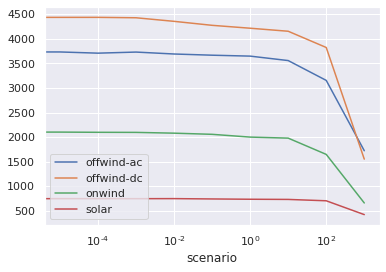

In [91]:
df_FLH_all_assets.iloc[0:10].plot()
plt.xscale("log")
print(abs(df_FLH_all_assets.loc[1].values - df_FLH_all_assets.loc[0.0].values)/df_FLH_all_assets.loc[0.0].values)


print(df_FLH_all_assets.loc[0])
print(df_FLH_all_assets.loc[1])

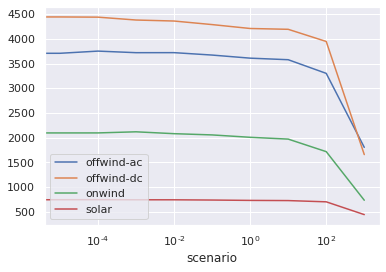

In [74]:
df_FLH_all_assets.iloc[10:20].plot()
plt.xscale("log")

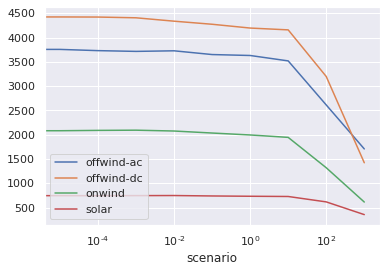

In [75]:
df_FLH_all_assets.iloc[20:30].plot()
plt.xscale("log")

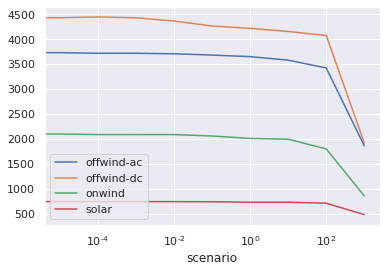

In [76]:
df_FLH_all_assets.iloc[30:40].plot()
plt.xscale("log")